In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing import image


In [2]:
IMAGE_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plates_number",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2033 files belonging to 12 classes.


In [5]:
class_names = dataset.class_names

In [6]:
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'pa']

In [7]:
for images_batch , label_batch in dataset.take(1):
    print(images_batch.shape)
    print(label_batch.numpy())

(32, 150, 150, 3)
[ 8  7 11  3 11  7  3  1 10 10  8  3  5  9 10  4  3  6  8  9 10  0  4  2
  1  7  2  9  0  6  2 11]


2023-11-04 18:16:50.591469: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-11-04 18:16:50.591911: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2033]
	 [[{{node Placeholder/_0}}]]


In [8]:
for images_batch , label_batch in dataset.take(1):
    print(images_batch[0].shape)
    
    

(150, 150, 3)


2023-11-04 18:16:51.974619: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-11-04 18:16:51.974968: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2033]
	 [[{{node Placeholder/_0}}]]


2023-11-04 18:16:53.596024: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-11-04 18:16:53.596412: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


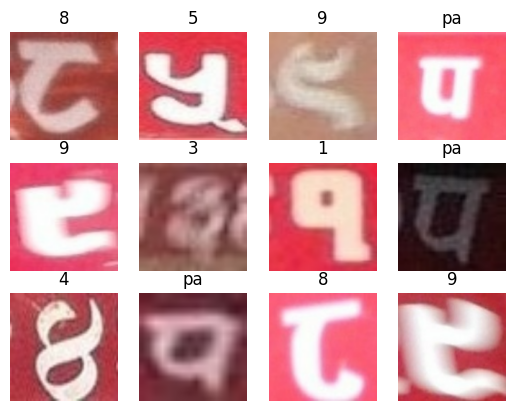

In [9]:
for images_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [10]:
len(dataset)

64

In [11]:
#80% Training
#10% Validation
#10% Testing

In [12]:
train_size = 0.8
len(dataset)*train_size


51.2

In [13]:
train_Dataset = dataset.take(51)
len(train_Dataset)

51

In [14]:
test_Dataset = dataset.skip(54)
len(test_Dataset)

10

In [15]:
val_size = 0.1
val_ds = test_Dataset.take(6)
len(val_ds)

6

In [16]:
test_dss = test_Dataset.skip(6)
len(test_dss)

4

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

    ds_size = len(ds)

    if shuffle:

        ds = ds. shuffle (shuffle_size, seed=12)

    train_size = int(train_split * ds_size)

    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds. skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_Dataset , val_ds , test_dss = get_dataset_partitions_tf(dataset)

In [19]:
len(train_Dataset)


51

In [20]:
len(val_ds)

6

In [21]:
len(test_dss)

7

In [22]:
train_Dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dss.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])


In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
n_classes = 12
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,3,padding="same",activation="relu",input_shape =input_shape ),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(n_classes , activation = "softmax")
])
model.build(input_shape= input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 150, 150, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 150, 150, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 150, 150, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 75, 75, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 75, 75, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 37, 37, 32)          0         
 g2D)                                                 

In [27]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [28]:
model.fit(
    train_Dataset,
    validation_data = val_ds,
    epochs = EPOCHS,
    batch_size= BATCH_SIZE,
    verbose = 1
)

Epoch 1/50


2023-11-04 18:17:25.646264: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-11-04 18:17:25.646633: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


51/51 [==============================] - ETA: 0s - loss: 2.4731 - accuracy: 0.1039

2023-11-04 18:17:34.241665: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2033]
	 [[{{node Placeholder/_0}}]]
2023-11-04 18:17:34.241900: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2033]
	 [[{{node Placeholder/_0}}]]


51/51 [==============================] - 10s 159ms/step - loss: 2.4731 - accuracy: 0.1039 - val_loss: 2.4530 - val_accuracy: 0.1198
Epoch 2/50
51/51 [==============================] - 9s 156ms/step - loss: 2.4625 - accuracy: 0.1224 - val_loss: 2.4180 - val_accuracy: 0.1562
Epoch 3/50
51/51 [==============================] - 9s 157ms/step - loss: 2.4212 - accuracy: 0.1447 - val_loss: 2.3338 - val_accuracy: 0.2203
Epoch 4/50
51/51 [==============================] - 9s 159ms/step - loss: 2.3588 - accuracy: 0.1756 - val_loss: 2.2851 - val_accuracy: 0.2712
Epoch 5/50
51/51 [==============================] - 9s 162ms/step - loss: 2.2792 - accuracy: 0.2132 - val_loss: 2.1535 - val_accuracy: 0.3177
Epoch 6/50
51/51 [==============================] - 8s 153ms/step - loss: 2.2213 - accuracy: 0.2451 - val_loss: 2.1619 - val_accuracy: 0.2656
Epoch 7/50
51/51 [==============================] - 9s 167ms/step - loss: 2.1313 - accuracy: 0.2894 - val_loss: 1.9067 - val_accuracy: 0.4062
Epoch 8/50
51/51

In [29]:
scores = model.evaluate(test_Dataset)

2023-11-04 18:25:19.615779: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-11-04 18:25:19.616085: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


10/10 [==============================] - 2s 79ms/step - loss: 0.7183 - accuracy: 0.7607


In [30]:
history

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing import image
IMAGE_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plates_number",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plates_number",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
class_names = dataset.class_names
class_names
for images_batch , label_batch in dataset.take(1):
    print(images_batch.shape)
    print(label_batch.numpy())
for images_batch , label_batch in dataset.take(1):
    print(images_batch[0].shape)
for images_batch , label_batch in dataset.take(1):
   

In [96]:
History

keras.src.callbacks.History

2023-11-04 18:25:27.037541: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]
2023-11-04 18:25:27.037930: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2033]
	 [[{{node Placeholder/_4}}]]


7


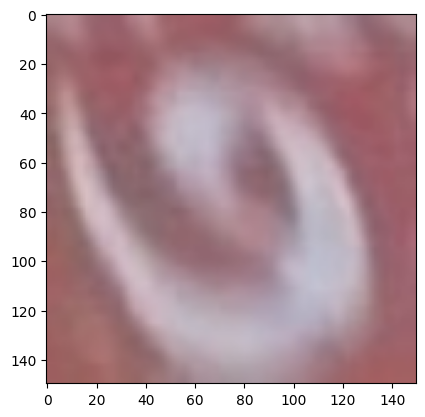

Actual Label:  7
1/1 [==============================] - 0s 140ms/step
Predicted Label:  7


In [31]:
import numpy as np 
for images_batch ,label_batch in test_Dataset.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print(first_label)
    plt.imshow(first_image)
    plt.show()

    
    print("Actual Label: ",class_names[first_label])
    prediction = model.predict(np.array([first_image]))
    predicted_label = np.argmax(prediction)
    print("Predicted Label: ",class_names[predicted_label])

In [32]:
def predic(model ,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    prediction = model.predict(img_array)
    score = tf.nn.softmax(prediction[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)],100*np.max(score)))

    return prediction,np.argmax(score)

In [34]:
model_version = 1.0
model_name = "Plates_number"

model.save(f"../NPV/model/{model_name,model_version}")
model.save('model.h5')
    

INFO:tensorflow:Assets written to: ../NPV/model/('Plates_number', 1.0)/assets


INFO:tensorflow:Assets written to: ../NPV/model/('Plates_number', 1.0)/assets
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 62ms/step


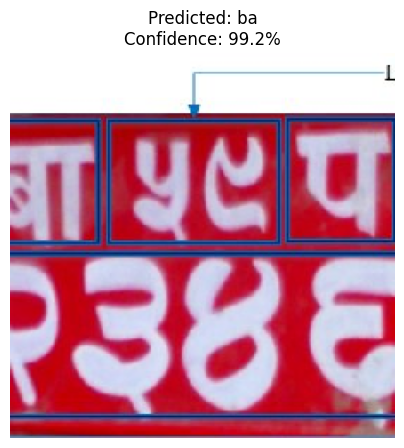

1/1 [==============================] - 0s 40ms/step

THE PREDICTED CLASS IS :- ba


In [37]:
def load_and_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")
    plt.show()


def load_and_predict_class(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    print("\nTHE PREDICTED CLASS IS :- "+predicted_class)
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    
   


image_path = '../Model_Build/License.jpg'


load_and_predict(model, image_path)
load_and_predict_class(model, image_path)